<a href="https://colab.research.google.com/github/icosahedron10/cifar10-cnn/blob/main/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 Classification Using Neural Networks

The CIFAR-10 dataset is one of the most widely used benchmark datasets for image classification tasks. It consists of 50,000 32x32 color training images and 10,000 test images across 10 classes, with 6,000 images per class. The classes present in CIFAR-10 are airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. This dataset has been widely used for a variety of computer vision tasks and has become a staple in the field.

CIFAR-10 was introduced in 2009 and has since been used in many studies and papers to evaluate the performance of various computer vision algorithms. In the years since its release, numerous researchers have attempted to improve upon the state-of-the-art performance on this dataset through the use of more advanced algorithms and architectures. Additionally, the dataset has also been used as a starting point for transfer learning, where pre-trained models on CIFAR-10 are fine-tuned for other image classification tasks. As a result of its widespread use, the CIFAR-10 dataset has become a key reference for the development of new computer vision algorithms and architectures.

The intention of this notebook is to introduce others to the different layers of convolutional neural networks (CNN) by using the CIFAR-10 dataset. CNNs have become the dominant architecture for image classification tasks due to their ability to automatically learn features from the input data. By implementing different layers of CNNs, including normalizing, pooling, and fully connected layers, this notebook will demonstrate how these layers work together to produce accurate image classifications. Through this, the goal is to provide a comprehensive understanding of CNNs and their implementation using the CIFAR-10 dataset. By the end of this notebook, readers will be equipped with the knowledge to build their own ConvNets and tackle other image classification tasks.

We begin this exploration by loading the full dataset in and exploring the shape of the data. We confirm below that the images are 3-channel images (RGB). There are 50,000 images in the training set, 10,000 images in the training set, and a separate vector of integer labels for each classifying images into the 10 classes. The images are 32 pixels tall and 32 pixels wide, meaning each image contains 1024 pixels and each of those pixels is defined by three integer values corresponding to it's RGB value.

In [1]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
import numpy as npy
import matplotlib.pyplot as plt
import visualkeras
import seaborn as sbn

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout 
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Load the data from Keras
cifar10_full = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10_full.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


As previously mentioned, the classes are equally represented so we won't focus on resampling methods. Below, we will randomly sample some images from the test set and display them in a figure. Note that the photos can be quite blurry at this resolution, and it can be difficult to tell what some of them are despite leveraging human intuition. This serves to prove a point: any classifier for this data is unlikely to do extremely well due to the quality of the images. 

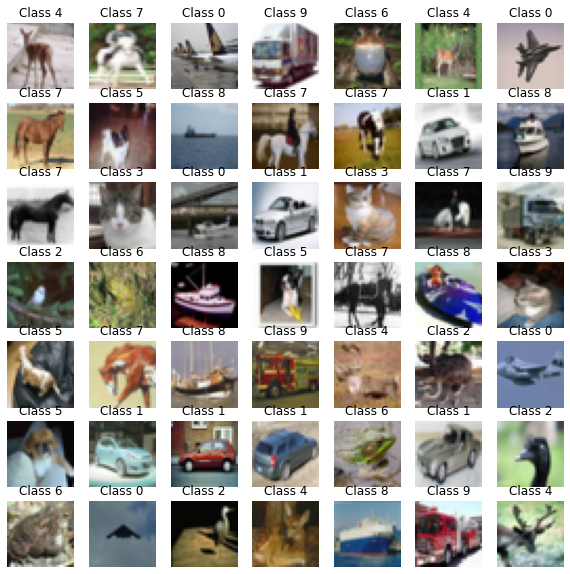

In [4]:
# Choose 49 random images and their labels from the training data
indices = npy.random.choice(x_train.shape[0], 49, replace=False)
images = x_train[indices]
labels = y_train[indices][:, 0]

# Plot the images
fig, ax = plt.subplots(nrows=7, ncols=7, figsize=(10, 10))
ax = ax.ravel()

# iterate over the images and labels
for i, (image, label) in enumerate(zip(images, labels)):
    ax[i].imshow(npy.squeeze(image))
    ax[i].set_title(f'Class {label}')
    ax[i].axis('off')

# display the plot
plt.show()

Now that we have some intuition built for the data, we will now preprocess the data in anticipation of the model we will eventually use. Specifically, each picture we have is a three-channel (RGB) image with each cell value being an integer in [0, 255] corresponding to the intensity associated with a particular color channel for a specific pixel in some image. We will normalize these values via min-max normalization by dividing by 255. This ensures that our model be more robust to the scale of inputs, as this will promote convergence and stability in our trained models.

In [5]:
# The R/G/B values for the 14th pixel of the second row, first picture
x_train[0, 1, 14]

array([109,  70,  33], dtype=uint8)

In [6]:
# min-max normalization
x_train = x_train / 255
x_test = x_test / 255

x_train[0, 1, 14]

array([0.42745098, 0.2745098 , 0.12941176])

The class labels we were given will similarly need some work done before they are suitable for model training. In their given state, each image has a single integer associated with it that identifies its class; however, the output of our neural network will have ten real values between 0 and 1 corresponding to the probability of that image belonging to any specific class. In this way, we will use One-Hot Encoding on the class labels to create a ten dimensional series of integers identifying each picture'c class.

In [7]:
# The class label for the third picture, class 9
y_train[2]

array([9], dtype=uint8)

In [8]:
# One-hot encoding the class labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

y_train[2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

With our data treated, we are now ready to begin classification techniques. This notebook reads like a progression through CNN layers and their particular roles. For this reason, the first model we will evaluate will be a bare-bones, naive CNN consisting of a dense network preceeded by two convolutional layers.

These convolutional layers each take in two-dimensional images as inputs, and parse over the inputs using kernal matrices. These kernals are square matrices comprised of weights that will update through the training process. Many images are created pixel-by-pixel by sliding these kernal matrices over the original image and computing the dot product between them. The many created images (also called convolutions) are then aggregated together to form the final output image.

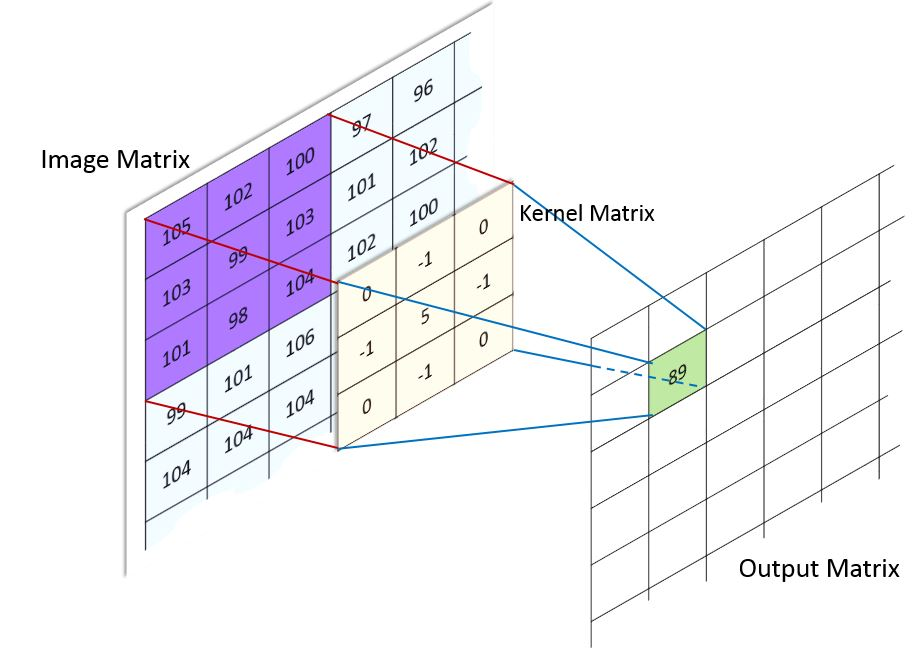

It is necessary for these convolutional layers to eventually be flattened to one-dimension, as the output of CNNs is a one-dimensional array. A dense network is normally used to connect the convolutional layers to the final output, as these comparitively computationally-efficient layers add another way for our network to pick up on patterns in image data.

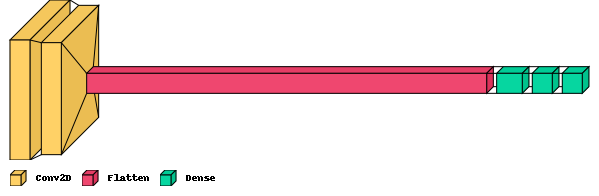

In [9]:
model = Sequential()

# First convolution
model.add(Conv2D(filters = 32, 
                 kernel_size = (3, 3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu'))

# Second Convolution
model.add(Conv2D(filters = 64, 
                 kernel_size = (3, 3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu'))

# Flatten 2D to 1D followed by dense network
model.add(Flatten())
model.add(Dense(256,  activation = 'relu'))
model.add(Dense(128,  activation = 'relu'))

# Output layer
model.add(Dense(10,  activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

# Visualize the model
visualkeras.layered_view(model, legend = True)

In [10]:
# Early stopping criteria for model training
# Will stop early if 5 epochs with no improvement to 'val_loss'
stopping_criteria = EarlyStopping(monitor = 'val_loss',
                                  patience = 5)

# Creating training-validation split
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.2)

# Training the CNN on training set, using validation set for metrics
trained_model = model.fit(X_train, Y_train,
                          validation_data = (X_val, Y_val),
                          batch_size = 32,
                          epochs = 100,
                          callbacks = [stopping_criteria],
                          verbose = 0
                          )

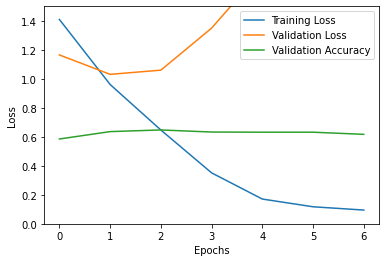

In [11]:
# Plotting the loss/accuracy by epoch
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.plot(trained_model.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim((0, 1.5))
plt.legend(['Training Loss', 'Validation Loss', 'Validation Accuracy'])
plt.show()

In [12]:
# Final evaluation of the model on the test dataset
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 2.2599 - accuracy: 0.6190


[2.2598648071289062, 0.6190000176429749]

From the above plot, we can see that our naive CNN very quickly overfit the training data. The model does not contain the complexity needed in order to generalize. In fact, for every epoch after the first we saw our validation loss increase. 

In [13]:
# Creating report of class precision/recall
predict_x = model.predict(x_test) 
print(classification_report(npy.argmax(y_test, axis=1),
                            npy.argmax(predict_x,axis=1)))

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.62      0.71      0.66      1000
           1       0.77      0.72      0.75      1000
           2       0.46      0.53      0.50      1000
           3       0.43      0.37      0.40      1000
           4       0.59      0.53      0.55      1000
           5       0.47      0.63      0.54      1000
           6       0.71      0.68      0.69      1000
           7       0.69      0.65      0.67      1000
           8       0.80      0.69      0.74      1000
           9       0.74      0.68      0.71      1000

    accuracy                           0.62     10000
   macro avg       0.63      0.62      0.62     10000
weighted avg       0.63      0.62      0.62     10000



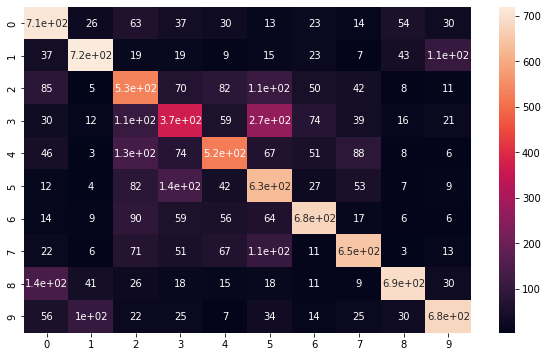

In [14]:
# Plotting heatmap of test set, x=classified, y=truth
plt.figure(figsize = (10, 6))
sbn.heatmap(confusion_matrix(npy.argmax(y_test, axis=1),
                            npy.argmax(predict_x,axis=1)), 
            annot = True);

The heatmap above lets us know where our naive model was most wrong in its preditcions. It looks like our model predicted class 5 (dogs) far more often than the truth. We can also see that the classes for which our predictions are the worst are class 3 (cats) and class 4 (deer).

# Max Pooling
The first additional layers that we will add to the model will be max pooling layers that follow each convolutional layer. These layers break the output images from the convolutional layers into smaller images through an algorithmic process. In our example, we have selected a pool size of (2, 2) which means that the input image will be broken into non-overlapping 2x2 matrices with the intention being that only one of the four pixel values in each pool will be kept. In this way, we expect the size of the input image to be reduced by half in each dimension. Max pooling refers to the process of keeping the max pixel value from each pool, whereas other pooling methods select the value different ways. Pooling layers help to reduce the complexity of our CNN and helps to prevent overfitting.

In [15]:
model = Sequential()

model.add(Conv2D(filters = 32, 
                 kernel_size = (3, 3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
# MaxPooling2D added to the end of every block of convolutions

model.add(Conv2D(filters = 64, 
                 kernel_size = (3, 3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
# MaxPooling2D added to the end of every block of convolutions

model.add(Flatten())
model.add(Dense(256,  activation = 'relu'))
model.add(Dense(128,  activation = 'relu'))

model.add(Dense(10,  activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

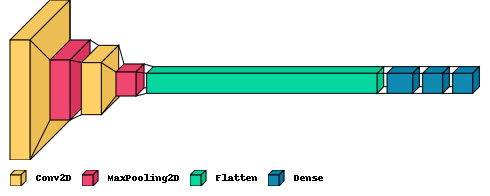

In [16]:
visualkeras.layered_view(model, legend = True)

In [17]:
trained_model = model.fit(X_train, Y_train,
                          validation_data = (X_val, Y_val),
                          batch_size = 32,
                          epochs = 100,
                          callbacks = [stopping_criteria],
                          verbose = 0
                          )

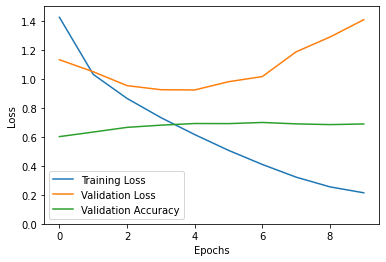

In [18]:
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.plot(trained_model.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim((0, 1.5))
plt.legend(['Training Loss', 'Validation Loss', 'Validation Accuracy'])
plt.show()

We can see that the pooling layers have helped in reign in the overfitting somewhat, but it is still a huge issue.

In [19]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.4294 - accuracy: 0.6874


[1.4293993711471558, 0.6873999834060669]

In [20]:
predict_x = model.predict(x_test) 
print(classification_report(npy.argmax(y_test, axis=1),
                            npy.argmax(predict_x,axis=1)))

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.72      0.76      0.74      1000
           1       0.77      0.82      0.80      1000
           2       0.62      0.56      0.59      1000
           3       0.51      0.50      0.51      1000
           4       0.61      0.62      0.62      1000
           5       0.60      0.55      0.57      1000
           6       0.79      0.70      0.74      1000
           7       0.70      0.77      0.73      1000
           8       0.84      0.78      0.81      1000
           9       0.71      0.81      0.76      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000



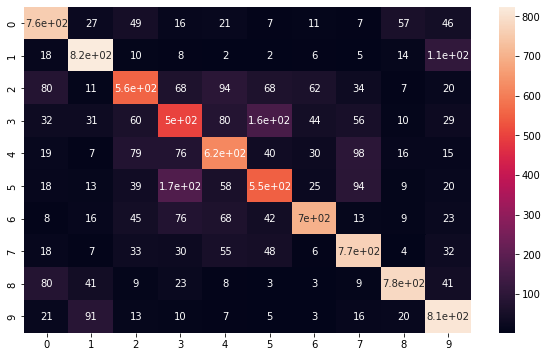

In [21]:
plt.figure(figsize = (10, 6))
sbn.heatmap(confusion_matrix(npy.argmax(y_test, axis=1),
                            npy.argmax(predict_x,axis=1)), 
            annot = True);

The pooling layers were enough for our model to classify a few percent more records correctly when compared to the naive model; however, it is clear that the same classification issues exist in this new model as well. 

# Model Size and Resolution
When implementing image classification CNNs, it is important to provide enough layers to pick up on the intricate patterns hidden in images. In addition, it is important to preserve all sources of information from the input images.

The next model that we will implement will fix both of these issues. In particular, we will add five additional convolutional layers to pick up on more sophisticated patterns in the images. To aid in this, we will gradually increase the number of kernals used in each convolutional layer. This is done because ideally the first convolutional layers in our model will pick up on the more prominant patterns in the images, with the layers later in the model having many more kernals to pick up on granular patterns.

In addition to these additional layers, we will now zero-pad the input images to these convolutional layers. In previous models, the input images were necessarily larger than the output due to the kernals behavior at the edges of our image. This reduction in size ultimately amounts to a loss in information that we should avoid if possible. By padding an appropriate number of zeros around the image, we can ensure that the information contained at it's edges will be retained to the next layer.

In [22]:
# Increased the number of blocks of convolutions
# Increased the number of convolutions per block in come cases
# Changed to padding = 'same'
# Number of kernels increases with depth

model = Sequential()

model.add(Conv2D(filters = 32, 
                 kernel_size = (3, 3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu',
                 padding = 'same'))
model.add(Conv2D(filters = 32, 
                 kernel_size = (3, 3),
                 input_shape = (32, 32, 3),  
                 activation = 'relu',
                 padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(filters = 64, 
                 kernel_size = (3, 3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu',
                 padding = 'same'))
model.add(Conv2D(filters = 64, 
                 kernel_size = (3, 3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu',
                 padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(filters = 128, 
                 kernel_size = (3, 3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu',
                 padding = 'same'))
model.add(Conv2D(filters = 256, 
                 kernel_size = (3, 3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu',
                 padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(filters = 516, 
                 kernel_size = (3, 3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu',
                 padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))

model.add(Dense(10, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

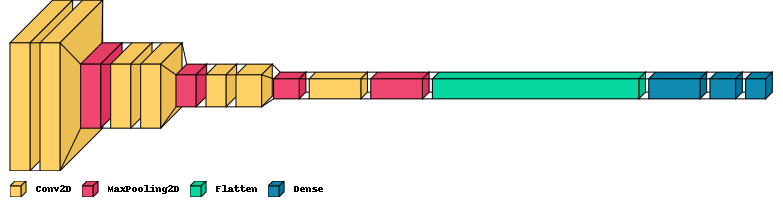

In [23]:
visualkeras.layered_view(model, legend = True)

In [24]:
trained_model = model.fit(X_train, Y_train,
                          validation_data = (X_val, Y_val),
                          batch_size = 32,
                          epochs = 100,
                          callbacks = [stopping_criteria],
                          verbose = 0
                          )

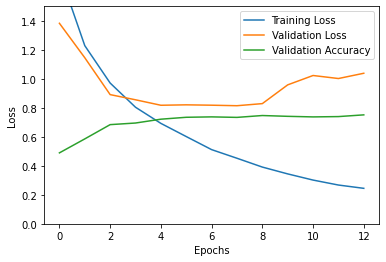

In [25]:
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.plot(trained_model.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim((0, 1.5))
plt.legend(['Training Loss', 'Validation Loss', 'Validation Accuracy'])
plt.show()

It is immediately apparant that the complexity of the new model has made a huge difference in our model's ability to learn.

In [26]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.0665 - accuracy: 0.7453


[1.066499948501587, 0.7452999949455261]

In [27]:
predict_x = model.predict(x_test) 
print(classification_report(npy.argmax(y_test, axis=1),
                            npy.argmax(predict_x,axis=1)))

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.76      0.82      0.79      1000
           1       0.87      0.87      0.87      1000
           2       0.72      0.58      0.64      1000
           3       0.55      0.56      0.56      1000
           4       0.70      0.67      0.68      1000
           5       0.63      0.67      0.65      1000
           6       0.79      0.81      0.80      1000
           7       0.74      0.78      0.76      1000
           8       0.87      0.85      0.86      1000
           9       0.84      0.84      0.84      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.74     10000
weighted avg       0.75      0.75      0.74     10000



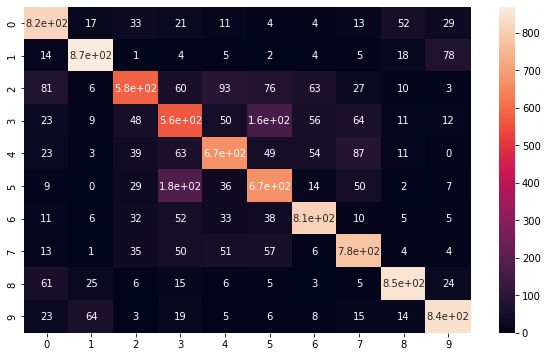

In [28]:
plt.figure(figsize = (10, 6))
sbn.heatmap(confusion_matrix(npy.argmax(y_test, axis=1),
                            npy.argmax(predict_x,axis=1)), 
            annot = True);

From the above heatmap, we can see that 

# Dropout Layers
The first regularization layers we will add to our model will be dropout layers. These are layers that have input sizes that match the output size of the preceeding layer, and are responsible for "switching off" some of the neurons in our model. Specifically, each forward pass through our network will draw a series of Bernoulli trials, one for each neuron in the dropout layer, with the success probability for the trials specified by the function. With a successful draw, the neuron corresponding to that trial will be set to zero.

This technique is used to create a more robust and general network that does not rely too heavily on any particular pattern in the images. This helps to prevent overfitting. The probability of success for the dropout layer is a very important parameter to consider, as large probabilities can eliminate any information learned in the model.

In [29]:
model = Sequential()

model.add(Conv2D(filters = 32, 
                 kernel_size = (3, 3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu',
                 padding = 'same'))
model.add(Conv2D(filters = 32, 
                 kernel_size = (3, 3),
                 input_shape = (32, 32, 3),  
                 activation = 'relu',
                 padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.3))
# Dropout layer added to the end of each convolution block

model.add(Conv2D(filters = 64, 
                 kernel_size = (3, 3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu',
                 padding = 'same'))
model.add(Conv2D(filters = 64, 
                 kernel_size = (3, 3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu',
                 padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.3))
# Dropout layer added to the end of each convolution block

model.add(Conv2D(filters = 128, 
                 kernel_size = (3, 3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu',
                 padding = 'same'))
model.add(Conv2D(filters = 256, 
                 kernel_size = (3, 3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu',
                 padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.3))
# Dropout layer added to the end of each convolution block

model.add(Conv2D(filters = 516, 
                 kernel_size = (3, 3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu',
                 padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.3))
# Dropout layer added to the end of each convolution block

# Dropout layer also follows every dense layer, save for the output
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

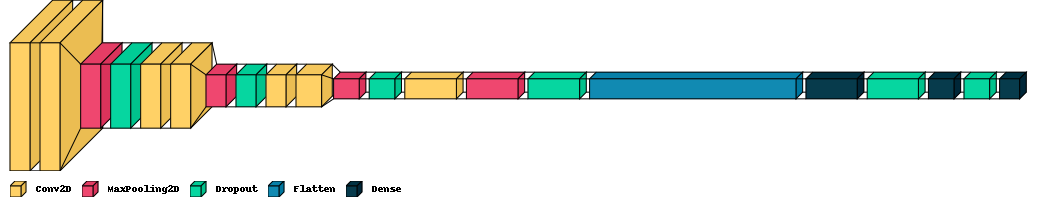

In [30]:
visualkeras.layered_view(model, legend = True)

In [31]:
trained_model = model.fit(X_train, Y_train,
                          validation_data = (X_val, Y_val),
                          batch_size = 32,
                          epochs = 100,
                          callbacks = [stopping_criteria],
                          verbose = 0
                          )

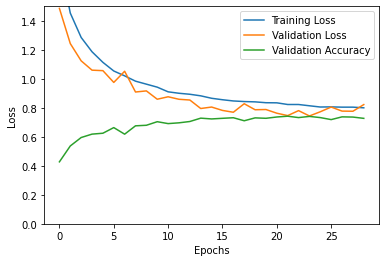

In [32]:
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.plot(trained_model.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim((0, 1.5))
plt.legend(['Training Loss', 'Validation Loss', 'Validation Accuracy'])
plt.show()

We can see the effects of dropout layers significantly impacts our models ability to generalize. Training loss matches with validation loss for the majority of this plot, which implies that the model was not fitting well enough to the training data. This could be due to the nature of dropout layers without some other form of normalization.

In [33]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.8398 - accuracy: 0.7214


[0.8398371934890747, 0.7214000225067139]

In [34]:
predict_x = model.predict(x_test) 
print(classification_report(npy.argmax(y_test, axis=1),
                            npy.argmax(predict_x,axis=1)))

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.87      0.63      0.73      1000
           1       0.92      0.85      0.88      1000
           2       0.71      0.54      0.61      1000
           3       0.55      0.51      0.53      1000
           4       0.67      0.68      0.67      1000
           5       0.71      0.57      0.64      1000
           6       0.51      0.95      0.66      1000
           7       0.85      0.73      0.79      1000
           8       0.84      0.86      0.85      1000
           9       0.80      0.90      0.85      1000

    accuracy                           0.72     10000
   macro avg       0.74      0.72      0.72     10000
weighted avg       0.74      0.72      0.72     10000



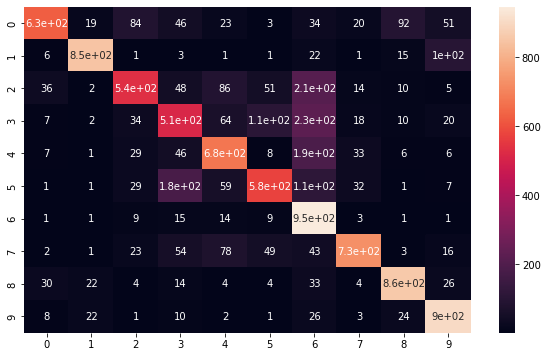

In [35]:
plt.figure(figsize = (10, 6))
sbn.heatmap(confusion_matrix(npy.argmax(y_test, axis=1),
                            npy.argmax(predict_x,axis=1)), 
            annot = True);

We can see from the heatmap above that this model has predicted far more frogs than there was in truth, and the same issue is present with misclassifying cats and dogs.

# Batch Normalization
Batch normalization layers have input size that matches the preceeding layer, and have equal output size. For each batch of data and forward pass performed, we will scale the activations by subtracting off the mean of it's respective batch and dividing by standard deviation of the batch. Each activation is then scaled and shifted by a pair of parameters that are trained through backpropagation. The purpose of this layer is to normalize and transform the activations throughout the training process. This directly combats the problem of internal covariance shift, in which the activation values either grow or shrink based on updated weights in the backpropigation process. Normalizing these activations provides stability of the model, prevents overfitting, and increases the rate of convergence.

With batch normalization being completed in addition to dropout, neurons that are set to zero will be scaled and transformed away from zero. This is particularly important because too many zeros in the computation of gradient decent can cause the model to perform extremely poorly.


In [36]:


model = Sequential()

# BatchNormalization() added to the end of every convoluion
model.add(Conv2D(filters = 32, 
                 kernel_size = (3,3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu',
                 padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, 
                 kernel_size = (3,3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu',
                 padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.5))
# NOTE: Dropout() only after MaxPooling() due to interaction

# BatchNormalization() added to the end of every convoluion
model.add(Conv2D(filters = 64, 
                 kernel_size = (3,3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu',
                 padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, 
                 kernel_size = (3,3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu',
                 padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.5))
# NOTE: Dropout() only after MaxPooling() due to interaction

# BatchNormalization() added to the end of every convoluion
model.add(Conv2D(filters = 128, 
                 kernel_size = (3,3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu',
                 padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 256, 
                 kernel_size = (3,3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu',
                 padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.5))
# NOTE: Dropout() only after MaxPooling() due to interaction

# BatchNormalization() added to the end of every convoluion
model.add(Conv2D(filters = 512, 
                 kernel_size = (3,3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu',
                 padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# NOTE: Dropout() after MaxPooling() due to interaction

# BatchNormalization() also added to the end of every dense layer
# NOTE: Dropout() only after MaxPooling() due to interaction
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(10, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

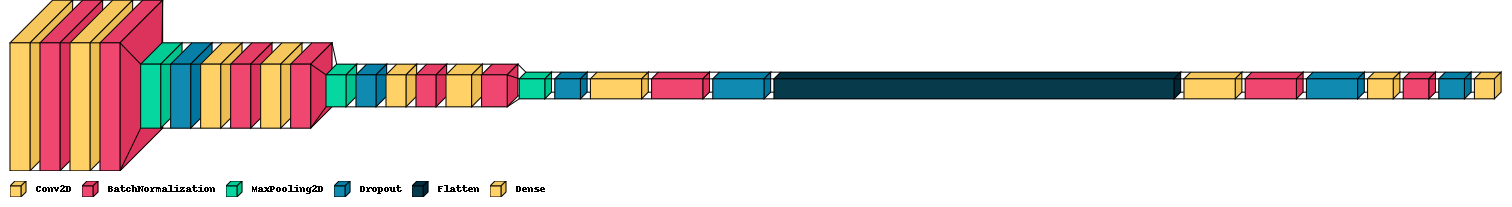

In [37]:
visualkeras.layered_view(model, legend = True)

In [38]:
trained_model = model.fit(X_train, Y_train,
                          validation_data = (X_val, Y_val),
                          batch_size = 32,
                          epochs = 100,
                          callbacks = [stopping_criteria],
                          verbose = 0
                          )

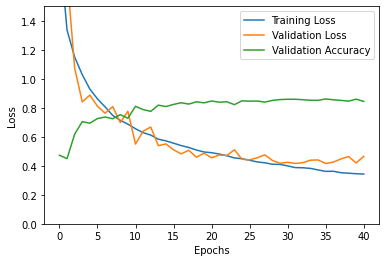

In [39]:
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.plot(trained_model.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim((0, 1.5))
plt.legend(['Training Loss', 'Validation Loss', 'Validation Accuracy'])
plt.show()

The above plot shows a clearly improved model training as expected: our validation accuracy steadily increasing, training loss exponentially decreasing, and a training process that ends before validation loss would indicate overfitting. Any further improvements to this model will be incremental compared to the jump between this model and the ones that have come before.

In [40]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.4836 - accuracy: 0.8391


[0.483615905046463, 0.8391000032424927]

In [41]:
predict_x = model.predict(x_test) 
print(classification_report(npy.argmax(y_test, axis=1),
                            npy.argmax(predict_x,axis=1)))

313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1000
           1       0.92      0.92      0.92      1000
           2       0.81      0.75      0.78      1000
           3       0.81      0.59      0.68      1000
           4       0.81      0.84      0.83      1000
           5       0.74      0.82      0.77      1000
           6       0.81      0.93      0.87      1000
           7       0.90      0.88      0.89      1000
           8       0.89      0.91      0.90      1000
           9       0.82      0.95      0.88      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



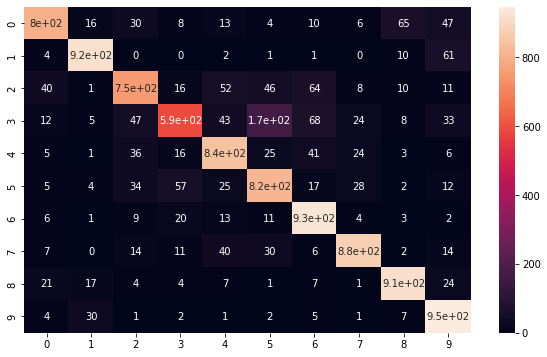

In [42]:
plt.figure(figsize = (10, 6))
sbn.heatmap(confusion_matrix(npy.argmax(y_test, axis=1),
                            npy.argmax(predict_x,axis=1)), 
            annot = True);

Although this model is doing a significantly better job at classifying the test set, we can still glean some information from the above heatmap. Namely, we know that our model is repeatedly confusing cats for dogs, as the vast majority of its misclassifications come in that cell. We will explore more techniques of regularization to attempt to improve this models ability to discern the intricate differences between images of cats and images of dogs.

# Data Augmentation
The final technique we will use to help our model generalize is data augmentation. Simply put, data augmentation increases the number of images that are availble to be sampled when the batches are created before each forward pass. These new input images are created by augmenting the existing training set with certain transformations, such as flips, shifts, and rotations. This technique is most useful when the training dataset is too small to do meaningful analysis on, which is not the case with the CIFAR-10 dataset; however, we may see some increase in performance by adding this feature to our model.

In [43]:
# Same model as last time

model = Sequential()

model.add(Conv2D(filters = 32, 
                 kernel_size = (3,3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu',
                 padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, 
                 kernel_size = (3,3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu',
                 padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, 
                 kernel_size = (3,3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu',
                 padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, 
                 kernel_size = (3,3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu',
                 padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, 
                 kernel_size = (3,3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu',
                 padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 256, 
                 kernel_size = (3,3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu',
                 padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 512, 
                 kernel_size = (3,3), 
                 input_shape = (32, 32, 3), 
                 activation = 'relu',
                 padding = 'same'))
model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(10, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

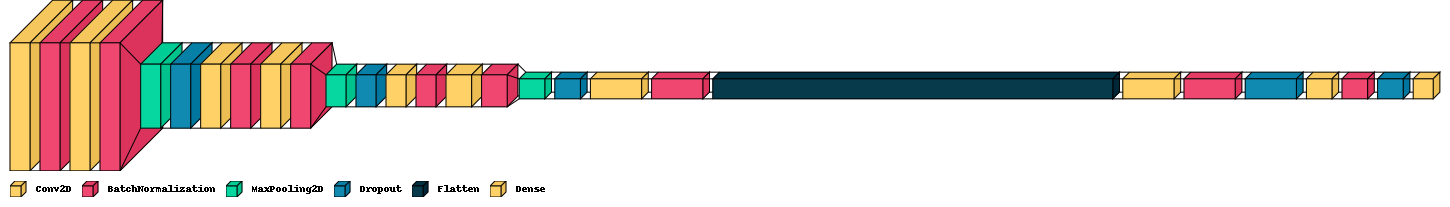

In [44]:
visualkeras.layered_view(model, legend = True)

In [45]:
# Create data generator instance, specify data source and batch size
# Use generator instead of training data in model.fit()
data_generator = ImageDataGenerator(width_shift_range=0.1, 
                                    height_shift_range=0.1, 
                                    horizontal_flip=True)
train_generator = data_generator.flow(X_train, Y_train, 32)

trained_model = model.fit(train_generator,
                          validation_data = (X_val, Y_val),
                          batch_size = 32,
                          epochs = 100,
                          callbacks = [stopping_criteria],
                          verbose = 0
                          )

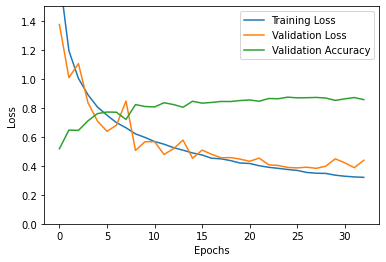

In [46]:
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.plot(trained_model.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim((0, 1.5))
plt.legend(['Training Loss', 'Validation Loss', 'Validation Accuracy'])
plt.show()

In [47]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.4583 - accuracy: 0.8515


[0.4582964777946472, 0.8514999747276306]

In [48]:
predict_x = model.predict(x_test) 
print(classification_report(npy.argmax(y_test, axis=1),
                            npy.argmax(predict_x,axis=1)))

313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1000
           1       0.96      0.92      0.94      1000
           2       0.88      0.76      0.82      1000
           3       0.81      0.63      0.71      1000
           4       0.84      0.82      0.83      1000
           5       0.85      0.73      0.79      1000
           6       0.66      0.97      0.78      1000
           7       0.91      0.92      0.91      1000
           8       0.89      0.96      0.92      1000
           9       0.90      0.94      0.92      1000

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000



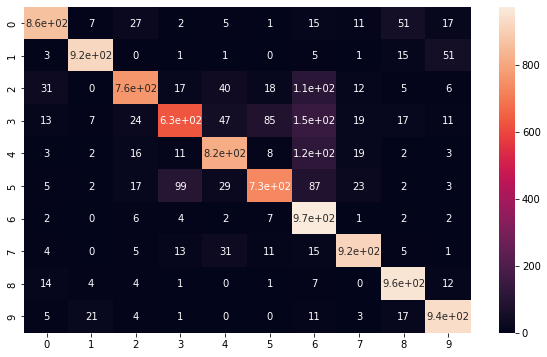

In [49]:
plt.figure(figsize = (10, 6))
sbn.heatmap(confusion_matrix(npy.argmax(y_test, axis=1),
                            npy.argmax(predict_x,axis=1)), 
            annot = True);

# Results
| Added Technique      | Test Accuracy |
| ----------- | ----------- |
| Naive      | 0.6190       |
| Max Pooling   | 0.6874        |
| Size and Resolution   | 0.7452        |
| Dropout   | 0.7214        |
| Batch Normalize   | 0.8391        |
| Data Augmentation   | 0.8515        |
